                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


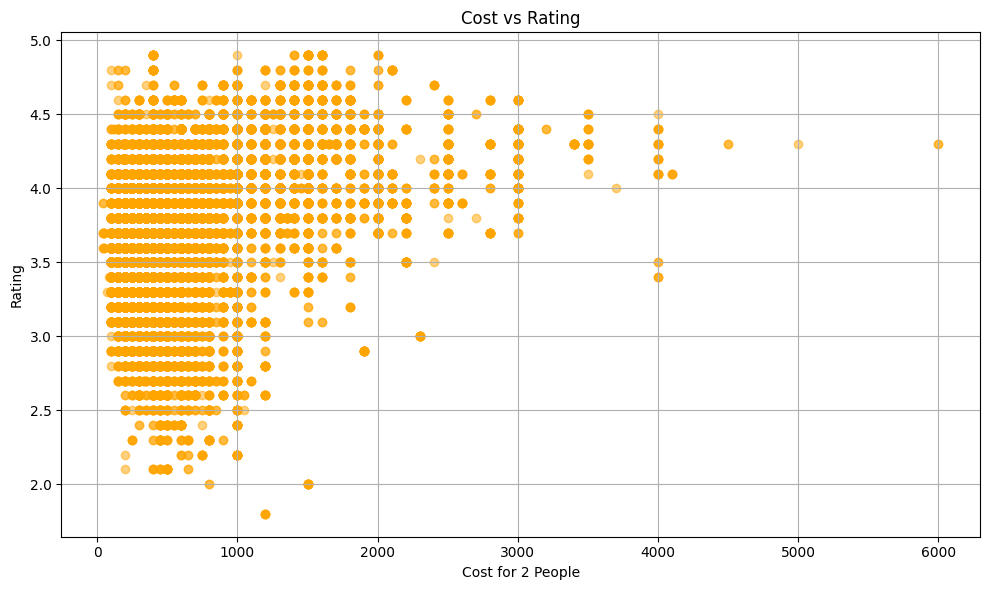

                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    

👉 Some insights from the data:

🍽️ Best Rated Cuisines (min 5 places):
              avg_rating  restaurant_count
cuisine                                  
Cantonese      4.600000                 6
African        4.523529                17
Singaporean    4.414894                47

🔥 Most Popular Cuisines by Votes:
               total_votes  avg_rating
cuisine                              
North Indian      6758373    3.641717
Continental       4319653    3.962046
Chinese           403529

In [8]:
# basic imports for data and plots
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import os
import logging

# ----------- Setup basic stuff -------------
file_name = "data.xlsx - zomato.csv"  # this is the zomato data file I got
save_folder = "output"                # folder where I'll save all my work
os.makedirs(save_folder, exist_ok=True)

logging.basicConfig(level=logging.INFO)  # just to see what's happening


# ----------- Load the data -------------
def get_data(path=file_name):
    logging.info("Getting data from file...")
    return pd.read_csv(path, encoding='latin1')


# ----------- Cleaning time -------------
def clean_up(df):
    df = df.copy()
    df.drop_duplicates(inplace=True)

    # fill empty stuff with zero (mostly ratings, votes, cost)
    df.fillna({'Rating': 0, 'votes': 0, 'approx_cost(for two people)': 0}, inplace=True)

    # make sure numbers are actually numbers
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
    df['approx_cost(for two people)'] = (
        df['approx_cost(for two people)']
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(float)
    )

    # make places and cuisines look nice
    df['location'] = df['location'].astype(str).str.strip().str.title()
    df['cuisines'] = df['cuisines'].astype(str).str.strip()

    # grab the first/main cuisine
    df['main_cuisine'] = df['cuisines'].str.split(',').str[0].str.strip().str.title()

    return df


# ----------- Break cuisines into rows -------------
def break_cuisines(df):
    df = df.copy()
    df['cuisine'] = df['cuisines'].str.split(',')
    df = df.explode('cuisine')
    df['cuisine'] = df['cuisine'].str.strip().str.title()
    return df


# ----------- Cuisine stats (avg, votes, etc) -------------
def get_cuisine_summary(df_expanded):
    return df_expanded.groupby('cuisine').agg({
        'Rating': 'mean',
        'votes': 'sum',
        'approx_cost(for two people)': 'mean',
        'name': 'count'
    }).rename(columns={
        'Rating': 'avg_rating',
        'votes': 'total_votes',
        'approx_cost(for two people)': 'avg_cost',
        'name': 'restaurant_count'
    }).sort_values(by='avg_rating', ascending=False)


# ----------- Show cool plots -------------
def make_bar_plot(df, colname, title, save_as):
    fig = px.bar(df.head(15), x=colname, y=df.head(15).index,
                 orientation='h', title=title)
    fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.write_html(f"{save_folder}/{save_as}.html")
    fig.show()


def scatter_plot_price_vs_rating(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['approx_cost(for two people)'], df['Rating'], alpha=0.5, color='orange')
    plt.title('Cost vs Rating')
    plt.xlabel('Cost for 2 People')
    plt.ylabel('Rating')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_folder}/price_vs_rating.png")
    plt.show()


# ----------- Print some insights -------------
def insights(df, cuisine_data):
    print("\n👉 Some insights from the data:\n")

    top_cuisine = cuisine_data[cuisine_data['restaurant_count'] > 5].sort_values('avg_rating', ascending=False).head(3)
    print("🍽️ Best Rated Cuisines (min 5 places):\n", top_cuisine[['avg_rating', 'restaurant_count']])

    popular_cuisine = cuisine_data.sort_values('total_votes', ascending=False).head(3)
    print("\n🔥 Most Popular Cuisines by Votes:\n", popular_cuisine[['total_votes', 'avg_rating']])

    expensive = df.groupby('main_cuisine')['approx_cost(for two people)'].mean().sort_values(ascending=False).head(3)
    print("\n💸 Most Expensive Main Cuisines:\n", expensive)

    top_places = df.sort_values(['Rating', 'votes'], ascending=[False, False]).head(5)
    print("\n🏆 Best Rated Restaurants:\n", top_places[['name', 'Rating', 'votes', 'main_cuisine']])


# ----------- Save results -------------
def save_files(df_clean, cuisine_summary):
    df_clean.to_csv(f"{save_folder}/cleaned_data.csv", index=False)
    cuisine_summary.to_csv(f"{save_folder}/cuisine_summary.csv")
    cuisine_summary.to_excel(f"{save_folder}/cuisine_summary.xlsx")
    cuisine_summary.to_json(f"{save_folder}/cuisine_summary.json", orient='records', lines=True)


# ----------- Let's gooo -------------
def main():
    raw = get_data()
    nice_data = clean_up(raw)
    exploded = break_cuisines(nice_data)
    stats = get_cuisine_summary(exploded)

    save_files(nice_data, stats)

    good_cuisines = stats[stats['restaurant_count'] > 5]

    make_bar_plot(good_cuisines.sort_values('avg_rating', ascending=False), 'avg_rating',
                  'Top Cuisines by Rating', 'top_rating_cuisines')
    print(" "*100)
    print("-"*100)
    print("-"*100)
    print("-"*100)
    print(" "*100)

    make_bar_plot(stats.sort_values('total_votes', ascending=False), 'total_votes',
                  'Most Voted Cuisines', 'top_voted_cuisines')

    print(" "*100)
    print("-"*100)
    print("-"*100)
    print("-"*100)
    print(" "*100)

    scatter_plot_price_vs_rating(nice_data)

    print(" "*100)
    print("-"*100)
    print("-"*100)
    print("-"*100)
    print(" "*100)
    insights(nice_data, stats)


if __name__ == "__main__":
    main()
